In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import shutil

TRAINING_DIR = "Training"

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2)

VALIDATION_DIR = "Validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size = 32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size= 4
)

Found 766 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
#model.summary()
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

87916544/87910968 [==============================] - 4s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 24,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 24
)

Epoch 1/100
24/24 [==============================] - 11s 455ms/step - loss: 4.5408 - acc: 0.5601 - val_loss: 1.0409 - val_acc: 0.7053
Epoch 2/100
24/24 [==============================] - 10s 401ms/step - loss: 1.0510 - acc: 0.7272 - val_loss: 0.4739 - val_acc: 0.7684
Epoch 3/100
24/24 [==============================] - 10s 404ms/step - loss: 0.8321 - acc: 0.7742 - val_loss: 1.7677 - val_acc: 0.6526
Epoch 4/100
24/24 [==============================] - 9s 395ms/step - loss: 0.5678 - acc: 0.8277 - val_loss: 0.2728 - val_acc: 0.8947
Epoch 5/100
24/24 [==============================] - 9s 395ms/step - loss: 0.5353 - acc: 0.8355 - val_loss: 0.8399 - val_acc: 0.7158
Epoch 6/100
24/24 [==============================] - 9s 394ms/step - loss: 0.5128 - acc: 0.8225 - val_loss: 0.1928 - val_acc: 0.9053
Epoch 7/100
24/24 [==============================] - 10s 398ms/step - loss: 0.4720 - acc: 0.8446 - val_loss: 0.2677 - val_acc: 0.8947
Epoch 8/100
24/24 [==============================] - 10s 396ms/st

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(
    train_generator,
    steps_per_epoch = 24,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 24
)
print(len(base_model.layers))

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

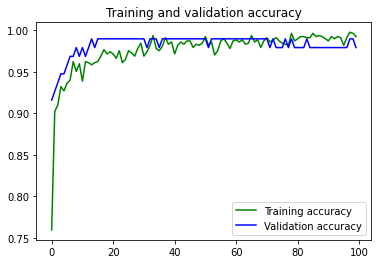

<Figure size 432x288 with 0 Axes>

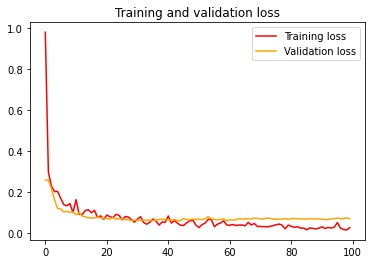

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('/content/drive/My Drive/covidieeedataset/incpetionacc2.png')
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('/content/drive/My Drive/covidieeedataset/incpetionloss2.png')
plt.figure()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/covidieeedataset/inceptionv3COVID100.h5')

In [ ]:
import tensorflow as tf 
model = tf.keras.models.load_model('/content/drive/My Drive/covidieeedataset/inceptionv3COVID100.h5')

In [ ]:
import numpy as np
from keras.preprocessing import image
import os
prediction = []
x = []
#paths = ['/content/drive/My Drive/COVID/VIRAL/Viral Pneumonia (102).jpg', '/content/drive/My Drive/COVID/NORMAL/NORMAL (102).jpg', '/content/drive/My Drive/COVID/images/Validation/covid/extubation-13.jpg']
paths = os.listdir('/content/drive/My Drive/covidieeedataset/Testing/COVID')
for i in range(len(paths)):
  img = image.load_img('/content/drive/My Drive/covidieeedataset/Testing/COVID/'+paths[i], target_size=(224, 224))
  #print(type(img))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x]) / 255
  #print(type(images))
  classes = model.predict(images, batch_size=256)
  prediction.append(list(classes[0]).index(max(classes[0])))
paths = os.listdir('/content/drive/My Drive/covidieeedataset/Testing/NORMAL')
for i in range(len(paths)):
  img = image.load_img('/content/drive/My Drive/covidieeedataset/Testing/NORMAL/'+paths[i], target_size=(224, 224))
  #print(type(img))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x]) / 255
  #print(type(images))
  classes = model.predict(images, batch_size=256)
  prediction.append(list(classes[0]).index(max(classes[0])))
paths = os.listdir('/content/drive/My Drive/covidieeedataset/Testing/VIRAL')
for i in range(len(paths)):
  img = image.load_img('/content/drive/My Drive/covidieeedataset/Testing/VIRAL/'+paths[i], target_size=(224, 224))
  #print(type(img))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x]) / 255
  #print(type(images))
  classes = model.predict(images, batch_size=256)
  prediction.append(list(classes[0]).index(max(classes[0])))

Using TensorFlow backend.


In [ ]:
import numpy
from sklearn import metrics

y_act = validation_generator.classes

labels = [0, 1, 2]

print(metrics.confusion_matrix(y_act, np.array(prediction), labels=labels))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, np.array(prediction), labels=labels))

[[25  0  0]
 [ 0 33  2]
 [ 1  1 33]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       0.97      0.94      0.96        35
           2       0.94      0.94      0.94        35

    accuracy                           0.96        95
   macro avg       0.96      0.96      0.96        95
weighted avg       0.96      0.96      0.96        95



In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
lbl = [0, 1, 2]
df_cm = pd.DataFrame(metrics.confusion_matrix(y_act, np.array(prediction), labels=lbl), 
                     ['COVID-19', 'Normal', 'Viral pneumonia'], 
                     ['COVID-19', 'Normal', 'Viral pneumonia'])

sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cbar=False,  cbar_kws={"orientation": "horizontal"})
plt.yticks(rotation=30) 
plt.savefig('confusionmatrixINCEPTION2.png')
plt.show()